# 时序差分方法(Temporal Difference,TD)

时序差分方法非常重要，本章的Sarsa,包括后面的Q-learning,DQN,Actor-Critic等算法，都包含时序差分方法在内。
<br>这里通过Sarsa，最简单的一个基于时序差分方法的算法，来学习时序差分。

本节介绍单步Sarsa,下一节介绍n-step-Sarsa

# 单步Sarsa更新公式的推导
以下是本人的理解，推导写的比较简略，可能不太规范或者有不对的地方，仅供参考，感谢批评指正!
<br>具体数学推导请看《强化学习的数学原理》第7章
<br>代码对应《动手学强化学习》第5章 [请点击这里](https://hrl.boyuai.com/chapter/1/%E6%97%B6%E5%BA%8F%E5%B7%AE%E5%88%86%E7%AE%97%E6%B3%95)

<img src="./picture5_1.png" alt="插入图片哈哈" width="80%">

# 环境
还是悬崖漫步环境

In [18]:
import matplotlib.pyplot as plt
import numpy as np
class CliffWalkingEnv:
    def __init__(self, ncol, nrow):
        self.nrow = nrow
        self.ncol = ncol
        self.x = 0              # 记录当前智能体位置的横坐标  。初始位置在左下角
        self.y = self.nrow - 1  # 记录当前智能体位置的纵坐标

    def step(self, action):  # 外部调用这个函数来改变当前位置
        # 4种动作, change[0]:上, change[1]:下, change[2]:左, change[3]:右。坐标系原点(0,0)
        # 定义在左上角
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self.x = min(self.ncol - 1, max(0, self.x + change[action][0]))
        self.y = min(self.nrow - 1, max(0, self.y + change[action][1]))
        next_state = self.y * self.ncol + self.x
        reward = -1
        done = False
        if self.y == self.nrow - 1 and self.x > 0:  # 下一个位置在悬崖或者目标
            done = True
            if self.x != self.ncol - 1:
                reward = -100
        return next_state, reward, done

    def reset(self):  # 回归初始状态,坐标轴原点在左上角
        self.x = 0
        self.y = self.nrow - 1
        return self.y * self.ncol + self.x

# 单步Sarsa

In [19]:
class Sarsa:
    """ Sarsa算法 """
    def __init__(self, ncol, nrow, epsilon, alpha, gamma, n_action=4):
        self.Q_table = np.zeros([nrow * ncol, n_action])  # 初始化Q(s,a)表格,二维列表，48行4列，每一列表示这个状态的4个动作只
        self.n_action = n_action  # 动作个数，4个动作
        self.alpha = alpha        # 学习率
        self.gamma = gamma        # 折扣因子
        self.epsilon = epsilon

    def take_action(self, state): # 选取下一步的操作,具体实现为epsilon-greedy
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            a = self.Q_table[state]
            action = np.random.choice(np.flatnonzero(a == a.max()))
        return action  #返回的是[0,3]的数字，对应动作

    def best_action(self, state):  # 用于打印策略
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):         # 若两个动作的价值一样,都会记录下来
            if self.Q_table[state, i] == Q_max:
                a[i] = 1
        return a

    def update(self, s0, a0, r, s1, a1):
        td_error = r + self.gamma * self.Q_table[s1, a1] - self.Q_table[s0, a0]
        self.Q_table[s0, a0] += self.alpha * td_error

# 训练

## 实例化

In [20]:
ncol = 12
nrow = 4
env = CliffWalkingEnv(ncol, nrow)
np.random.seed(0)
epsilon = 0.1
alpha = 0.1
gamma = 0.9
agent = Sarsa(ncol, nrow, epsilon, alpha, gamma)

## 开始训练

In [21]:
num_episodes = 1000
return_list = []
for i in range(num_episodes):
    episode_return = 0
    state = env.reset()     # 每次都是从同样的起点出发
    done = False
    while done == False:
        action = agent.take_action(state)            #根据当前的Q-talbe选择动作，0，1，2，3
        next_state, reward, done = env.step(action)
        next_action = agent.take_action(next_state)  # Q-learning没有这个,这是on-policy和off-policy的区别
        episode_return += reward                     # 这里回报的计算不进行折扣因子衰减,因为这里是用来绘图的
        agent.update(state, action, reward, next_state, next_action)   #更新Q
        state = next_state
        action = next_action
    return_list.append(episode_return)

## 训练结束

### 训练过程可视化

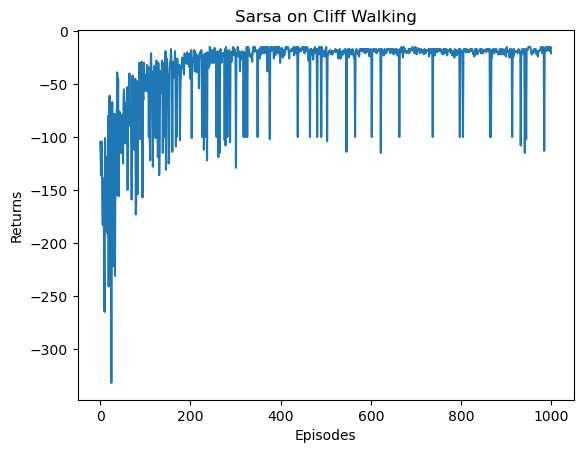

In [22]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Sarsa on {}'.format('Cliff Walking'))
plt.show()

### 打印q-table

In [23]:
agent.Q_table

array([[ -7.89777449,  -7.9787934 ,  -7.91880181,  -7.84067475],
       [ -7.68957329,  -7.91162842,  -7.95610706,  -7.60367611],
       [ -7.54149964,  -7.74509178,  -7.54496175,  -7.31630839],
       [ -7.2072928 ,  -7.06327391,  -7.27673607,  -7.0255336 ],
       [ -6.89487227,  -6.7290634 ,  -7.12850547,  -6.7083832 ],
       [ -6.54760811,  -6.42771597,  -6.72482442,  -6.30960915],
       [ -6.16530517,  -5.93821417,  -6.27892859,  -5.90147777],
       [ -5.71875094,  -5.48232898,  -5.82288784,  -5.39563525],
       [ -5.22822129,  -4.9147593 ,  -5.66891031,  -4.88411745],
       [ -4.57572709,  -4.36542764,  -4.74668472,  -4.33691352],
       [ -4.05218659,  -3.88979555,  -4.2960033 ,  -3.70749532],
       [ -3.43833564,  -2.94954721,  -3.63299802,  -3.30015083],
       [ -8.08445439,  -8.24715613,  -8.12150602,  -7.92539182],
       [ -7.87219126,  -7.96031765,  -8.07301467,  -7.64209548],
       [ -7.59623429, -10.57549103,  -7.64606721,  -7.30156728],
       [ -6.94447702, -10

### 策略可视化

In [24]:
def print_agent(agent, env, action_meaning, disaster=[], end=[]):
    for i in range(env.nrow):
        for j in range(env.ncol):
            if (i * env.ncol + j) in disaster:
                print('****', end=' ')
            elif (i * env.ncol + j) in end:
                print('EEEE', end=' ')
            else:
                a = agent.best_action(i * env.ncol + j)
                pi_str = ''
                for k in range(len(action_meaning)):
                    pi_str += action_meaning[k] if a[k] > 0 else 'o'
                print(pi_str, end=' ')
        print()

action_meaning = ['^', 'v', '<', '>']
print('Sarsa算法最终收敛得到的策略为：')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])

Sarsa算法最终收敛得到的策略为：
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo ^ooo ooo> ^ooo ^ooo oo<o oo<o ^ooo ooo> ooo> ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


Sarsa和MC的区别：
<br>MC先初始化Q和policy,从一个s,a出发，后续根据Q(policy)来选动作，完成一个episode后，再开始反向计算discounted return,更新Q,然后根据Q更新策略。
<br>Sarsa先初始化Q,然后从起点出发，根据Q选动作，后续是根据Q选动作
<br>MC是走完一个episode,走完这个episode了记录下来，然后开始反着算，反着算的过程中更新q表,而Sarsa是在走的过程中就在更新Q
<br>所以MC中有个generate_episode方法，而Sarsa中没有。
<br>Sarsa直接在训练的时候，设置多少个episode,走每一个episode的过程中,走到哪个s,a就更新哪个s,a,走的过程中就在更新q表
<br>MC是offline的，一个episode走完了才能开始更新，Sarsa是online的，走的过程中就在更新